In [452]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal


# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

In [453]:
files = [
    "example_speech_Andreas/180923214834-Y20UOTIE-text-000.wav",
    "example_speech_Andreas/181017140316-PM66PSO5-text-000.wav",
]
Fs1, audio1 = wavfile.read(files[0])
Fs2, audio2 = wavfile.read(files[1])
print(Fs1, Fs2)
print(audio1.shape, audio2.shape)
wavfile.write(
    "audio_preproc/combo.wav",
    Fs1,
    tools.stitch_frames([tools.preprocess(f, bpfilt=(20, 12000)) for f in files]),
)


44100 44100
(1988608, 2) (1380352, 2)
preprocessing 180923214834-Y20UOTIE-text-000
preprocessing 181017140316-PM66PSO5-text-000


## preprocess

In [454]:
# audio_original_path = "example_speech_Andreas/combo.wav"
# _ = tools.preprocess(audio_original_path, bpfilt=(20, 6000))




## Speech recognition

In [455]:
audio_path = "audio_preproc/combo_pp.wav"
Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"
if "model" not in locals():
    model = Model(model_path)

0 i ------------------- from 0.30 to 0.42 sec, confidence: 100.00%
1 skymningen ---------- from 0.42 to 1.29 sec, confidence: 100.00%
2 en ------------------ from 1.32 to 1.50 sec, confidence: 100.00%
3 mycket -------------- from 1.50 to 1.80 sec, confidence: 100.00%
4 het ----------------- from 1.83 to 2.10 sec, confidence: 100.00%
5 dag ----------------- from 2.10 to 2.43 sec, confidence: 100.00%
6 i ------------------- from 2.43 to 2.52 sec, confidence: 100.00%
7 början -------------- from 2.52 to 2.79 sec, confidence: 100.00%
8 av ------------------ from 2.79 to 2.88 sec, confidence: 100.00%
9 juli ---------------- from 2.91 to 3.36 sec, confidence: 100.00%
10 lämnade ------------- from 3.36 to 3.96 sec, confidence: 100.00%
11 en ------------------ from 3.96 to 4.14 sec, confidence: 100.00%
12 ung ----------------- from 4.14 to 4.41 sec, confidence: 100.00%
13 man ----------------- from 4.41 to 4.68 sec, confidence: 100.00%
14 sin ----------------- from 4.68 to 4.92 sec, confidence

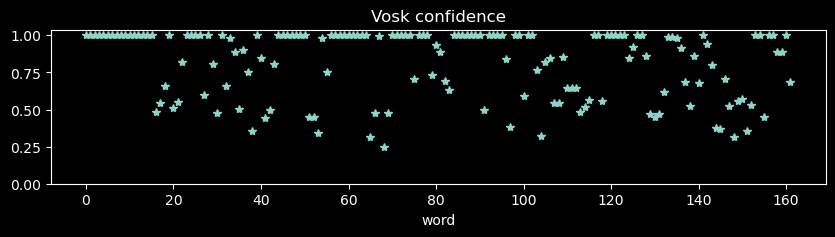

In [456]:
words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

In [457]:
# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)

for w in words:
    print(w["word"], w["vowels"], str(w["conf"] * 100) + "%")

i ['i'] 100.0%
skymningen ['y', 'i', 'e'] 100.0%
en ['e'] 100.0%
mycket ['y', 'e'] 100.0%
het ['e'] 100.0%
dag ['a'] 100.0%
i ['i'] 100.0%
början ['ö', 'a'] 100.0%
av ['a'] 100.0%
juli ['u', 'i'] 100.0%
lämnade ['ä', 'a', 'e'] 100.0%
en ['e'] 100.0%
ung ['u'] 100.0%
man ['a'] 100.0%
sin ['i'] 100.0%
kammare ['a', 'a', 'e'] 100.0%
som ['o'] 48.424099999999996%
man ['a'] 54.5871%
hörde ['ö', 'e'] 65.5527%
vid ['i'] 100.0%
är ['ä'] 51.285199999999996%
skogen ['o', 'e'] 55.326699999999995%
dig ['i'] 81.8257%
ut ['u'] 100.0%
på ['å'] 100.0%
gatan ['a', 'a'] 100.0%
och ['o'] 100.0%
började ['ö', 'a', 'e'] 60.099999999999994%
långsamt ['å', 'a'] 100.0%
och ['o'] 80.3728%
mässan ['ä', 'a'] 47.8091%
obeslutsam ['o', 'e', 'u', 'a'] 100.0%
jobba ['o', 'a'] 65.9465%
mot ['o'] 98.162%
jobben ['o', 'e'] 88.69120000000001%
lyckligtvis ['y', 'i', 'i'] 50.5381%
slapp ['a'] 90.0928%
han ['a'] 75.2549%
mäter ['ä', 'e'] 35.5657%
värdinnan ['ä', 'i', 'a'] 100.0%
i ['i'] 84.6815%
kappan ['a', 'a'] 44.3369%


## test 1 word

In [458]:
def HNR_short(frames, Fs, n_peaks=-1):
    """get frame index for peaks and hnr per frame"""
    hnr_frames = np.array([get_HNR(f, Fs) for f in frames])
    peaks, _ = signal.find_peaks(hnr_frames)
    peaks = peaks[(-peaks).argsort()[:n_peaks]]  # läskig one-liner
    return peaks, hnr_frames

mycket
------
frame length    : 882 samples
frame length    : 0.02 seconds
between frames  : 0.02 seconds
number of frames: 15


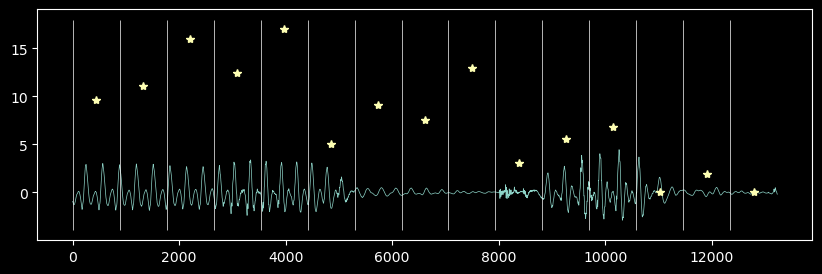

In [459]:
fl = int(0.02 * Fs)
k = 3
print(words[k]["word"])
print("-" * len(words[k]["word"]))
segments, vowels_per_segment = tools.segment_by_words(words, audio, Fs, tools.VOWELS_SV)
x = segments[k] / segments[k].std()
vowels = vowels_per_segment[k]


frames, f_start = tools.split_frames(x, fl, Fs, overlap=0, print_info=True)

peak_frames, hnr_frames = HNR_short(frames, Fs, len(vowels))

plt.figure(figsize=(10, 3))
plt.plot(x)
plt.plot(f_start + int(fl / 2), hnr_frames, "*")
plt.vlines(f_start, *plt.ylim())

plt.show()

In [460]:
grouped = {v: [] for v in tools.VOWELS_SV}
print(vowels)
print(len(frames))
print(len(peak_frames))

if len(peak_frames) == len(vowels):
    for i, v in enumerate(vowels):
        grouped[v].append(frames[peak_frames[i]])

['y', 'e']
15
2


## all words

In [461]:
grouped = {v: [] for v in tools.VOWELS_SV}
segments, vowels_per_segment = tools.segment_by_words(words, audio, Fs, tools.VOWELS_SV)
for w, segment, vowels in zip(words, segments, vowels_per_segment):
    if w["conf"] >= 1:
        print(w["word"], w["conf"])
        frames, f_start = tools.split_frames(segment, fl, Fs, overlap=0)
        peak_frames, hnr_frames = HNR_short(frames, Fs, len(vowels))
        if len(peak_frames) == len(vowels):
            for i, v in enumerate(vowels):
                grouped[v].append(frames[peak_frames[i]])

audio_out = {}
for v in grouped.keys():
    audio_out[v] = tools.stitch_frames(grouped[v], fade_pow=0.1)
    wavfile.write(f"output/concatenated/concatenated_{v}.wav", Fs, audio_out[v])


i 1.0
skymningen 1.0
en 1.0
mycket 1.0
het 1.0
dag 1.0
i 1.0
början 1.0
av 1.0
juli 1.0
lämnade 1.0
en 1.0
ung 1.0
man 1.0
sin 1.0
kammare 1.0
vid 1.0
ut 1.0
på 1.0
gatan 1.0
och 1.0
långsamt 1.0
obeslutsam 1.0
värdinnan 1.0
som 1.0
låg 1.0
alldeles 1.0
in 1.0
under 1.0
den 1.0
höga 1.0
liknande 1.0
snart 1.0
ska 1.0
jag 1.0
köpa 1.0
en 1.0
bostad 1.0
värdinnan 1.0
som 1.0
och 1.0
höll 1.0
honom 1.0
med 1.0
middag 1.0
snål 1.0
och 1.0


In [462]:
vowels_in_text = {v: 0 for v in tools.VOWELS_SV}
for c in tools.checkVowels(text, tools.VOWELS_SV):
    vowels_in_text[c] += 1

print("found vowels:")
for v in grouped.keys():
    print(
        "    ",
        v,
        len(grouped[v]),
        str(round(100 * len(grouped[v]) / vowels_in_text[v], 3)) + "%",
    )


found vowels:
     y 3 60.0%
     å 3 30.0%
     o 5 18.519%
     i 12 37.5%
     ä 9 45.0%
     u 3 20.0%
     ö 1 10.0%
     e 17 30.909%
     a 23 29.487%


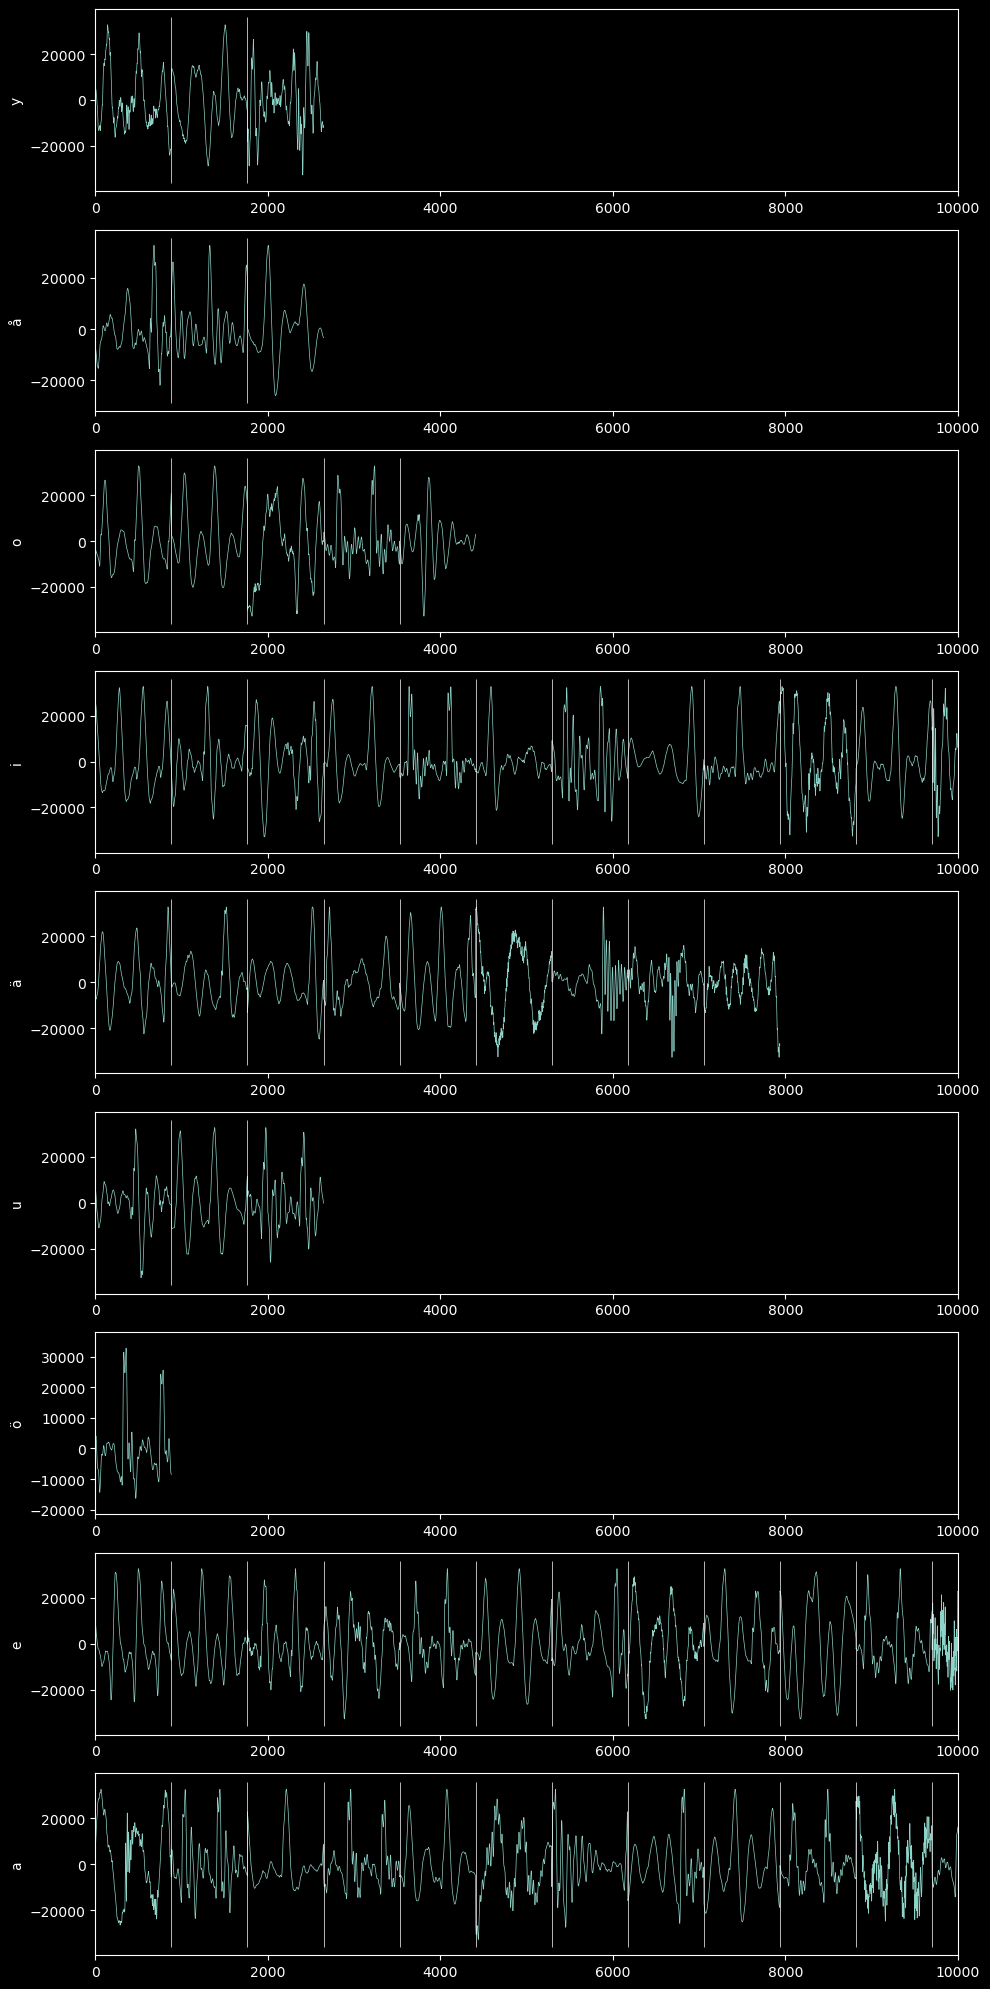

In [463]:
plt.figure(figsize=((10, 20)))
for i, v in enumerate(audio_out.keys()):
    plt.subplot(len(tools.VOWELS_SV), 1, i + 1)
    plt.plot(audio_out[v])
    plt.xlim(0, 10000)
    plt.vlines(np.arange(0, len(audio_out[v]), fl), *plt.ylim())
    plt.ylabel(v)

plt.tight_layout()
